## Clustering the Riders
Intro etc.

In [1]:
import sys
sys.path.append("..")

In [2]:
import pandas as pd
import numpy as np
from scipy.stats import mode
from sklearn.cluster import KMeans
from sklearn.pipeline import Pipeline
from src.dbops import fetch_riders, fetch_stages, assign_clusters
from src.kmeans_selection import PREPROCESSORS, compute_inertia_silhouette, plot_inertia_silhouette, model_summary

### Loading the Riders

In [3]:
project = ["name", "nationality", "weight", "height", "points"]
riders = fetch_riders(project=project)
riders = pd.json_normalize(riders)
riders.head()

,name,nationality,weight,height,points.classic,points.gc,points.tt,points.sprint,points.climber
0,david-zabriskie,United States,67.0,183.0,62,1058,3065,204,185
1,lance-armstrong,United States,72.0,178.0,3827,3642,3813,2732,1653
2,alexandre-vinokourov,Kazakhstan,68.0,177.0,3008,5726,4500,3510,3240
3,george-hincapie,United States,83.0,191.0,4618,2389,2331,4370,593
4,laszlo-bodrogi,France,NaN,187.0,828,1074,4949,796,76


### Exploring the Data

In [4]:
riders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1144 entries, 0 to 1143
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   name            1144 non-null   object 
 1   nationality     1144 non-null   object 
 2   weight          904 non-null    float64
 3   height          909 non-null    float64
 4   points.classic  1144 non-null   int64  
 5   points.gc       1144 non-null   int64  
 6   points.tt       1144 non-null   int64  
 7   points.sprint   1144 non-null   int64  
 8   points.climber  1144 non-null   int64  
dtypes: float64(2), int64(5), object(2)
memory usage: 80.6+ KB


In [5]:
riders["nationality"].value_counts().head()

Italy          229
France         143
Spain          142
Belgium         84
Netherlands     63
Name: nationality, dtype: int64

In [6]:
riders.describe()

,weight,height,points.classic,points.gc,points.tt,points.sprint,points.climber
count,904.000000,909.000000,1144.000000,1144.000000,1144.000000,1144.000000,1144.000000
mean,67.943164,179.734873,1012.689685,1124.481643,585.657343,1385.208042,689.392483
std,8.082813,6.288503,1422.739727,1366.344273,1060.479393,1953.592008,1141.749588
min,1.750000,159.000000,0.000000,0.000000,0.000000,1.000000,0.000000
25%,64.000000,175.000000,248.000000,316.750000,47.000000,317.750000,96.000000
50%,68.000000,180.000000,548.000000,660.000000,181.500000,751.500000,287.000000
75%,73.000000,184.000000,1170.250000,1343.250000,620.750000,1582.000000,774.500000
max,94.000000,199.000000,15680.000000,12409.000000,10687.000000,22714.000000,13660.000000


### Selecting the Best K-Means Model
#### Plotting the Inertia & Silhouette Score for Different Strategies

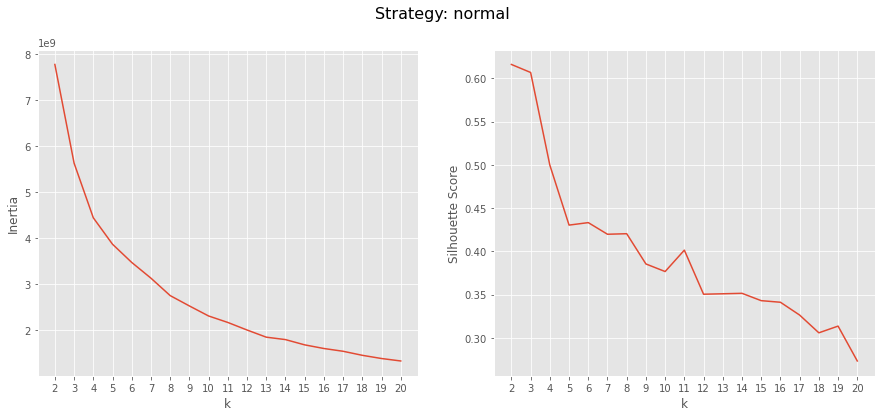

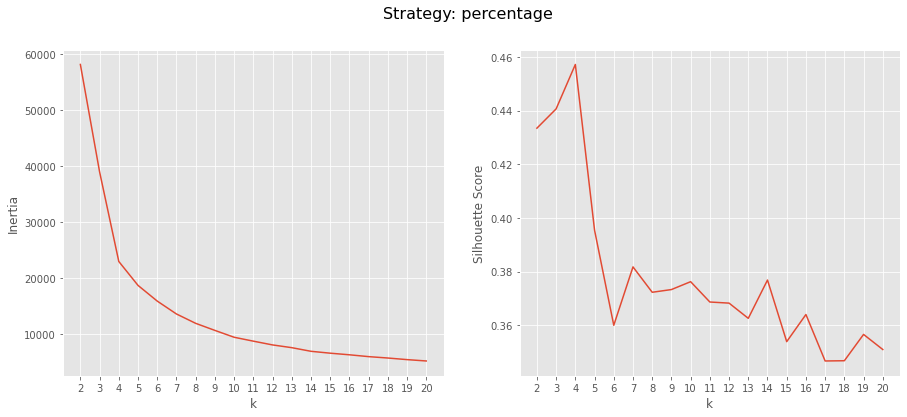

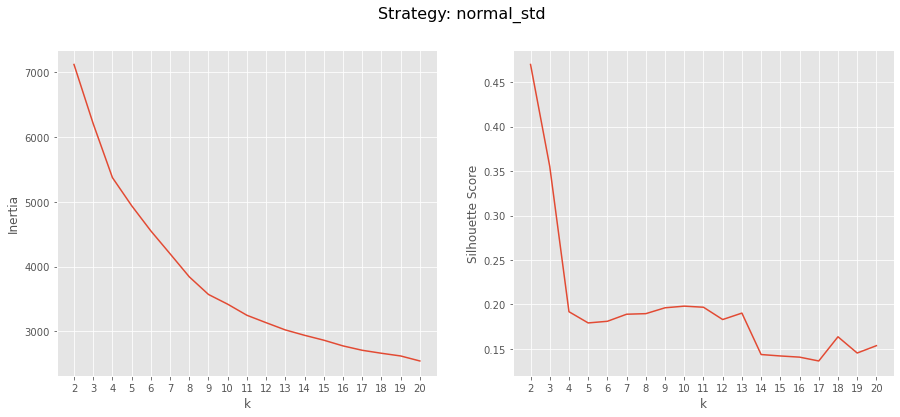

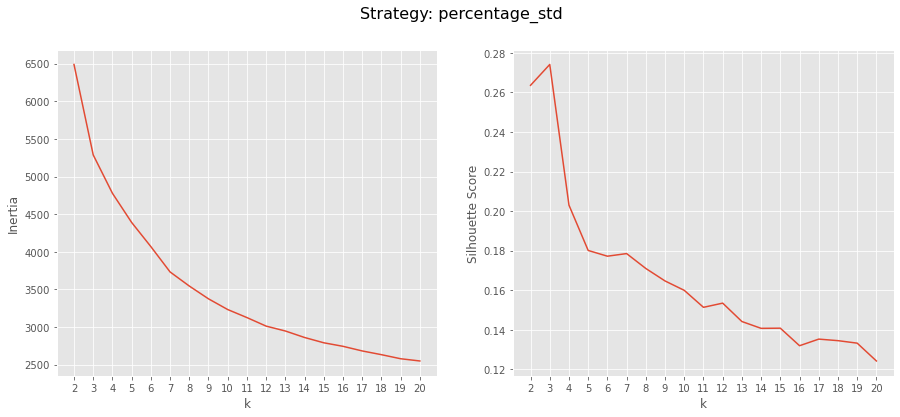

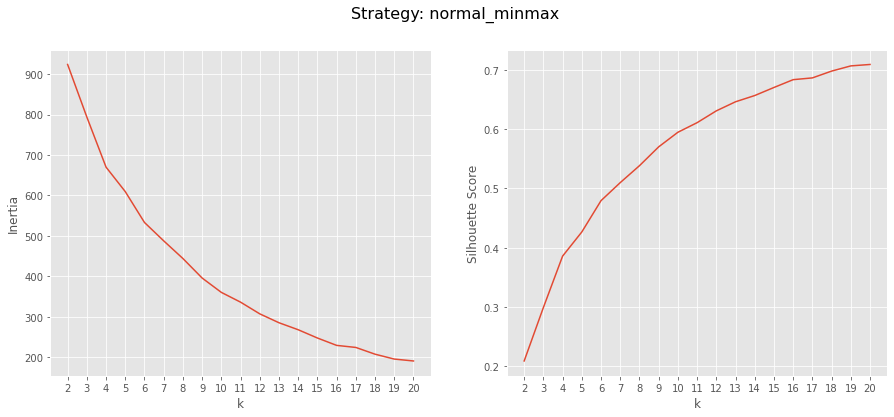

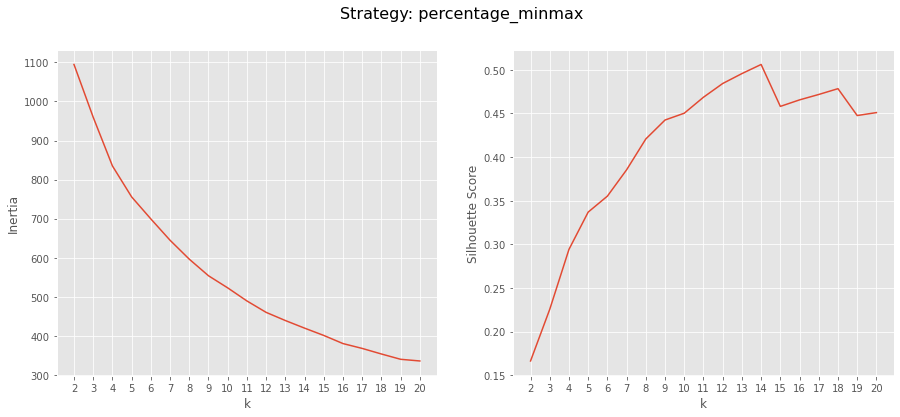

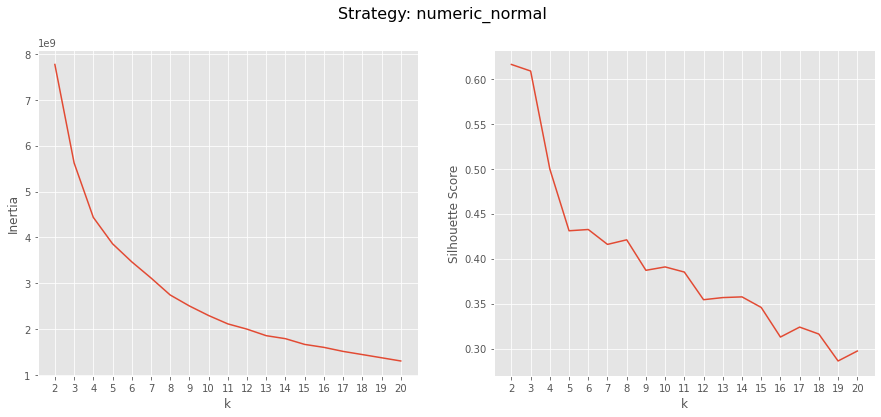

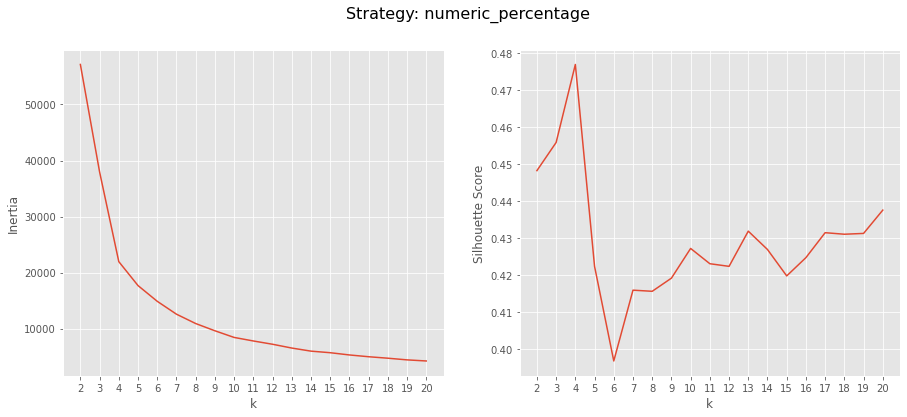

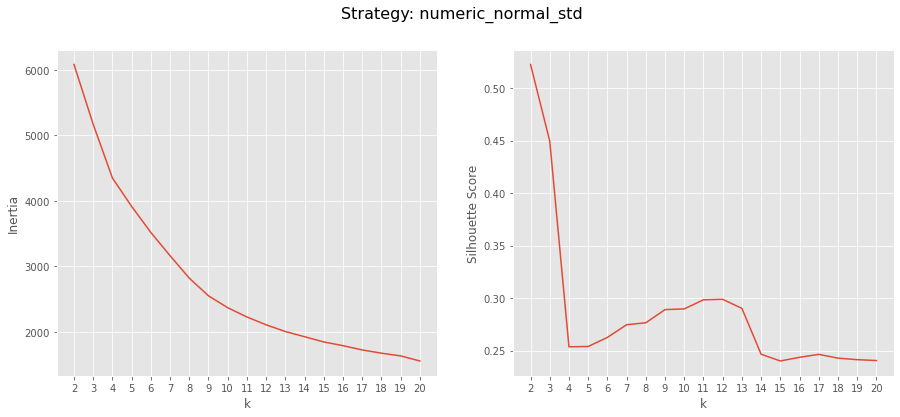

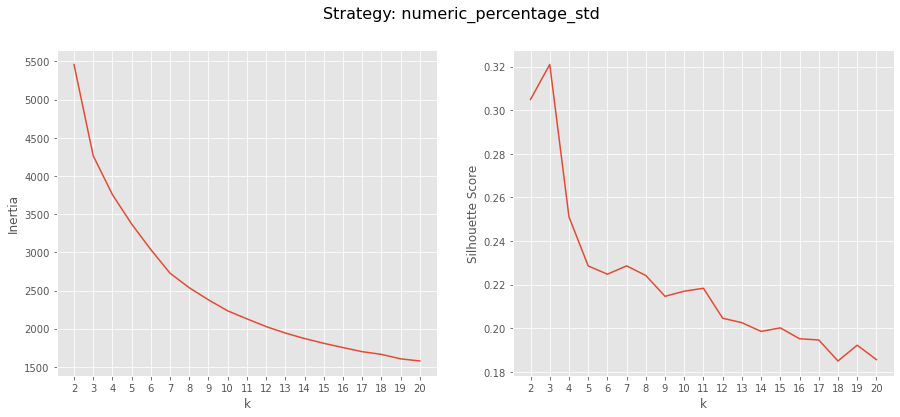

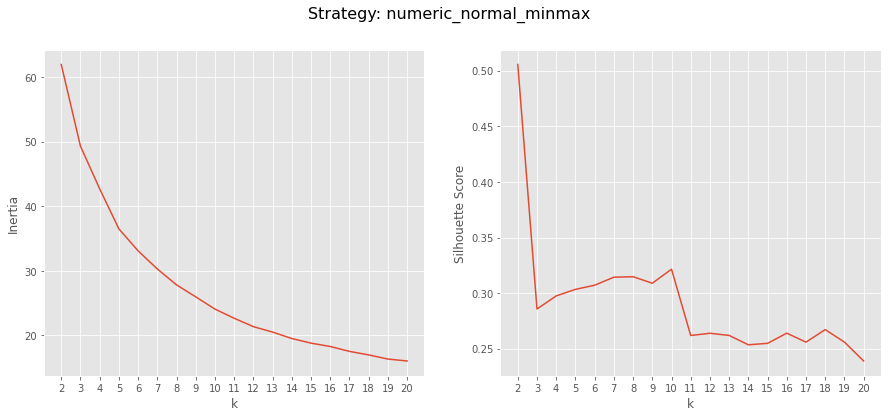

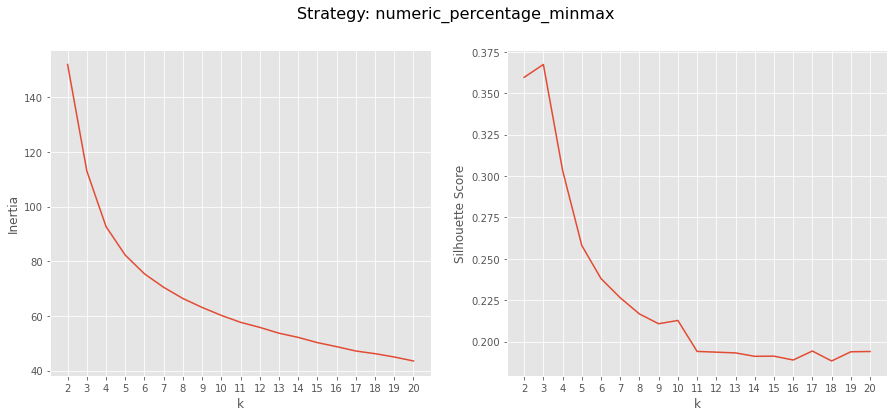

In [7]:
for strategy, preprocessor in PREPROCESSORS.items():
    inertia, silhouette = compute_inertia_silhouette(riders, preprocessor)
    plot_inertia_silhouette(inertia, silhouette, strategy)

#### Inspecting the Most Promising Combinations

In [8]:
# Summary for strat=normal, k=6
model_summary(riders, "normal", 6)

_____________K-Means with strategy 'normal' and 6 clusters: Summary_____________
Inertia: 3468583880.554872
Silhouette score: 0.4335147809213511

Riders in cluster 0: 727
Riders in cluster 1: 27
Riders in cluster 2: 160
Riders in cluster 3: 38
Riders in cluster 4: 23
Riders in cluster 5: 169

-----------------------------------Cluster 0------------------------------------
           weight      height  points.classic    points.gc    points.tt  \
count  554.000000  551.000000      727.000000   727.000000   727.000000   
mean    67.978556  180.370236      468.110041   537.324622   272.840440   
std      9.096339    6.493419      403.620600   382.135228   441.457914   
min      1.750000  164.000000        0.000000     0.000000     0.000000   
25%     64.000000  176.000000      167.000000   221.000000    31.500000   
50%     68.500000  180.000000      350.000000   471.000000   103.000000   
75%     73.000000  185.000000      642.000000   772.000000   307.500000   
max     94.000000  199.00

In [9]:
# Summary for strat=normal_, k=8
model_summary(riders, "normal", 8)

_____________K-Means with strategy 'normal' and 8 clusters: Summary_____________
Inertia: 2746285877.940745
Silhouette score: 0.4192915917530077

Riders in cluster 0: 673
Riders in cluster 1: 57
Riders in cluster 2: 160
Riders in cluster 3: 27
Riders in cluster 4: 12
Riders in cluster 5: 171
Riders in cluster 6: 6
Riders in cluster 7: 38

-----------------------------------Cluster 0------------------------------------
           weight      height  points.classic    points.gc    points.tt  \
count  509.000000  505.000000      673.000000   673.000000   673.000000   
mean    67.699646  180.340594      405.594354   530.655275   272.323923   
std      9.246453    6.484324      324.104922   379.236702   446.168596   
min      1.750000  164.000000        0.000000     0.000000     0.000000   
25%     63.000000  176.000000      152.000000   214.000000    31.000000   
50%     68.000000  180.000000      326.000000   465.000000   101.000000   
75%     72.000000  185.000000      568.000000   757.0

In [10]:
# Summary for strat=normal, k=10
model_summary(riders, "normal", 10)

____________K-Means with strategy 'normal' and 10 clusters: Summary_____________
Inertia: 2293925879.463868
Silhouette score: 0.40181399898498493

Riders in cluster 0: 123
Riders in cluster 1: 46
Riders in cluster 2: 34
Riders in cluster 3: 21
Riders in cluster 4: 192
Riders in cluster 5: 12
Riders in cluster 6: 6
Riders in cluster 7: 69
Riders in cluster 8: 46
Riders in cluster 9: 595

-----------------------------------Cluster 0------------------------------------
           weight      height  points.classic    points.gc    points.tt  \
count  110.000000  110.000000      123.000000   123.000000   123.000000   
mean    63.959091  177.527273      899.113821  2468.008130   739.504065   
std      5.096379    6.025495      589.498998   846.041753   613.565986   
min     48.000000  162.000000       45.000000   785.000000     2.000000   
25%     60.250000  174.000000      474.000000  1774.500000   268.000000   
50%     64.000000  177.000000      751.000000  2356.000000   607.000000   
75% 

In [11]:
# Summary for strat=percentage, k=10
model_summary(riders, "percentage", 10)

__________K-Means with strategy 'percentage' and 10 clusters: Summary___________
Inertia: 9471.12088686155
Silhouette score: 0.377955571768346

Riders in cluster 0: 106
Riders in cluster 1: 68
Riders in cluster 2: 364
Riders in cluster 3: 5
Riders in cluster 4: 103
Riders in cluster 5: 37
Riders in cluster 6: 144
Riders in cluster 7: 119
Riders in cluster 8: 82
Riders in cluster 9: 116

-----------------------------------Cluster 0------------------------------------
           weight      height  points.classic    points.gc    points.tt  \
count  101.000000  106.000000      106.000000   106.000000   106.000000   
mean    69.534653  185.377358      834.179245  1370.056604   741.537736   
std      1.780811    2.104204      948.241639  1437.925707  1081.734535   
min     65.000000  183.000000       40.000000    87.000000     0.000000   
25%     68.000000  184.000000      233.500000   418.500000   132.250000   
50%     70.000000  185.000000      529.000000   880.500000   297.000000   
75% 

In [12]:
# Summary for strat=normal_std, k=10
model_summary(riders, "normal_std", 10)

__________K-Means with strategy 'normal_std' and 10 clusters: Summary___________
Inertia: 3381.046815667054
Silhouette score: 0.1958878876382734

Riders in cluster 0: 161
Riders in cluster 1: 129
Riders in cluster 2: 167
Riders in cluster 3: 124
Riders in cluster 4: 5
Riders in cluster 5: 7
Riders in cluster 6: 30
Riders in cluster 7: 20
Riders in cluster 8: 448
Riders in cluster 9: 53

-----------------------------------Cluster 0------------------------------------
           weight      height  points.classic    points.gc    points.tt  \
count  160.000000  161.000000      161.000000   161.000000   161.000000   
mean    60.843750  171.670807      631.484472   804.422360   169.714286   
std      3.695224    3.467305      574.919767   560.033845   226.634630   
min     48.000000  159.000000        0.000000    30.000000     0.000000   
25%     58.000000  170.000000      228.000000   397.000000    33.000000   
50%     61.000000  172.000000      409.000000   656.000000    85.000000   
75% 

In [13]:
# Summary for strat=percentage_std, k=7
model_summary(riders, "percentage_std", 7)

_________K-Means with strategy 'percentage_std' and 7 clusters: Summary_________
Inertia: 3732.115747024088
Silhouette score: 0.17819248861858097

Riders in cluster 0: 205
Riders in cluster 1: 248
Riders in cluster 2: 137
Riders in cluster 3: 143
Riders in cluster 4: 241
Riders in cluster 5: 165
Riders in cluster 6: 5

-----------------------------------Cluster 0------------------------------------
           weight      height  points.classic    points.gc    points.tt  \
count  130.000000  133.000000      205.000000   205.000000   205.000000   
mean    69.684615  177.127820     1004.204878   363.141463   115.468293   
std      4.268207    4.504902     1130.692052   372.969699   225.904316   
min     59.000000  164.000000        2.000000     0.000000     0.000000   
25%     67.000000  174.000000      257.000000   119.000000    15.000000   
50%     69.000000  177.000000      631.000000   242.000000    46.000000   
75%     72.000000  180.000000     1347.000000   479.000000   114.000000  

In [14]:
# Summary for strat=normal_minmax, k=7
model_summary(riders, "normal_minmax", 7)

_________K-Means with strategy 'normal_minmax' and 7 clusters: Summary__________
Inertia: 497.10172339636944
Silhouette score: 0.5036346238710797

Riders in cluster 0: 144
Riders in cluster 1: 143
Riders in cluster 2: 229
Riders in cluster 3: 142
Riders in cluster 4: 339
Riders in cluster 5: 63
Riders in cluster 6: 84

-----------------------------------Cluster 0------------------------------------
           weight      height  points.classic    points.gc    points.tt  \
count  114.000000  115.000000      144.000000   144.000000   144.000000   
mean    68.513158  179.008696      813.166667  1015.319444   588.111111   
std      7.467469    7.542273     1159.867469  1213.552496  1190.432307   
min     55.000000  164.000000       10.000000     0.000000     0.000000   
25%     63.000000  173.000000      226.750000   315.000000    75.750000   
50%     69.000000  179.000000      431.000000   667.000000   209.500000   
75%     74.000000  184.000000      832.000000  1205.750000   510.000000  

In [15]:
# Summary for strat=normal_minmax, k=11
model_summary(riders, "normal_minmax", 11)

_________K-Means with strategy 'normal_minmax' and 11 clusters: Summary_________
Inertia: 328.79726831376973
Silhouette score: 0.6163033957380669

Riders in cluster 0: 142
Riders in cluster 1: 84
Riders in cluster 2: 143
Riders in cluster 3: 229
Riders in cluster 4: 63
Riders in cluster 5: 45
Riders in cluster 6: 266
Riders in cluster 7: 41
Riders in cluster 8: 59
Riders in cluster 9: 34
Riders in cluster 10: 38

-----------------------------------Cluster 0------------------------------------
          weight      height  points.classic     points.gc    points.tt  \
count  96.000000   96.000000      142.000000    142.000000   142.000000   
mean   65.562500  177.552083      717.147887   1565.408451   625.521127   
std     5.547522    4.945747     1381.111018   1924.242594  1052.036187   
min    53.000000  165.000000        0.000000     24.000000     0.000000   
25%    61.000000  174.000000      169.250000    398.750000    39.250000   
50%    65.000000  177.000000      335.000000   1015.

In [16]:
# Summary for strat=percentage_minmax, k=8
model_summary(riders, "percentage_minmax", 8)

_______K-Means with strategy 'percentage_minmax' and 8 clusters: Summary________
Inertia: 596.4088864283674
Silhouette score: 0.42081945970560364

Riders in cluster 0: 142
Riders in cluster 1: 229
Riders in cluster 2: 383
Riders in cluster 3: 143
Riders in cluster 4: 63
Riders in cluster 5: 59
Riders in cluster 6: 84
Riders in cluster 7: 41

-----------------------------------Cluster 0------------------------------------
          weight      height  points.classic     points.gc    points.tt  \
count  96.000000   96.000000      142.000000    142.000000   142.000000   
mean   65.562500  177.552083      717.147887   1565.408451   625.521127   
std     5.547522    4.945747     1381.111018   1924.242594  1052.036187   
min    53.000000  165.000000        0.000000     24.000000     0.000000   
25%    61.000000  174.000000      169.250000    398.750000    39.250000   
50%    65.000000  177.000000      335.000000   1015.000000   197.000000   
75%    70.000000  181.000000      675.000000   185

In [17]:
# Summary for strat=percentage_minmax, k=12
model_summary(riders, "percentage_minmax", 12)

_______K-Means with strategy 'percentage_minmax' and 12 clusters: Summary_______
Inertia: 459.9166666137887
Silhouette score: 0.4847395814161441

Riders in cluster 0: 229
Riders in cluster 1: 142
Riders in cluster 2: 59
Riders in cluster 3: 143
Riders in cluster 4: 84
Riders in cluster 5: 41
Riders in cluster 6: 63
Riders in cluster 7: 34
Riders in cluster 8: 45
Riders in cluster 9: 38
Riders in cluster 10: 148
Riders in cluster 11: 118

-----------------------------------Cluster 0------------------------------------
           weight      height  points.classic    points.gc    points.tt  \
count  131.000000  131.000000      229.000000   229.000000   229.000000   
mean    66.541985  177.557252     1334.965066   930.724891   349.410480   
std      6.034847    5.935759     1763.340893  1291.402039   649.029368   
min     52.000000  164.000000       16.000000     0.000000     0.000000   
25%     63.000000  173.500000      346.000000   214.000000    18.000000   
50%     67.000000  178.0000

In [18]:
# Summary for strat=numeric_normal, k=5
model_summary(riders, "numeric_normal", 5)

_________K-Means with strategy 'numeric_normal' and 5 clusters: Summary_________
Inertia: 3862866429.3089294
Silhouette score: 0.4303346768171099

Riders in cluster 0: 160
Riders in cluster 1: 183
Riders in cluster 2: 23
Riders in cluster 3: 720
Riders in cluster 4: 58

-----------------------------------Cluster 0------------------------------------
           weight      height  points.classic    points.gc    points.tt  \
count  124.000000  129.000000      160.000000   160.000000   160.000000   
mean    70.596774  178.782946     2311.712500   835.556250   295.268750   
std      5.466705    5.341408     1252.711838   655.268035   451.408456   
min     56.000000  159.000000      200.000000    38.000000     0.000000   
25%     67.000000  176.000000     1347.750000   339.750000    40.750000   
50%     71.000000  179.000000     2106.500000   667.000000   132.000000   
75%     74.000000  183.000000     3006.500000  1105.500000   341.500000   
max     83.000000  191.000000     6137.000000  3

In [19]:
# Summary for strat=numeric_normal, k=10
model_summary(riders, "numeric_normal", 10)

________K-Means with strategy 'numeric_normal' and 10 clusters: Summary_________
Inertia: 2303043194.1034617
Silhouette score: 0.376643832855339

Riders in cluster 0: 188
Riders in cluster 1: 25
Riders in cluster 2: 557
Riders in cluster 3: 12
Riders in cluster 4: 183
Riders in cluster 5: 22
Riders in cluster 6: 46
Riders in cluster 7: 49
Riders in cluster 8: 6
Riders in cluster 9: 56

-----------------------------------Cluster 0------------------------------------
           weight      height  points.classic    points.gc    points.tt  \
count  149.000000  151.000000      188.000000   188.000000   188.000000   
mean    71.130872  179.986755     1294.962766   569.505319   212.457447   
std      5.905047    6.300251      614.907170   374.280479   292.569299   
min     58.000000  164.000000      200.000000    15.000000     0.000000   
25%     67.000000  175.000000      815.250000   293.000000    32.750000   
50%     71.000000  180.000000     1196.500000   508.000000    98.500000   
75%  

In [20]:
# Summary for strat=numeric_percentage, k=10
model_summary(riders, "numeric_percentage", 10)

______K-Means with strategy 'numeric_percentage' and 10 clusters: Summary_______
Inertia: 8445.619069536157
Silhouette score: 0.42742744530576976

Riders in cluster 0: 364
Riders in cluster 1: 121
Riders in cluster 2: 5
Riders in cluster 3: 119
Riders in cluster 4: 138
Riders in cluster 5: 38
Riders in cluster 6: 109
Riders in cluster 7: 63
Riders in cluster 8: 96
Riders in cluster 9: 91

-----------------------------------Cluster 0------------------------------------
           weight      height  points.classic    points.gc    points.tt  \
count  132.000000  134.000000      364.000000   364.000000   364.000000   
mean    68.628788  180.119403      818.456044   874.656593   418.862637   
std      1.545273    1.476863     1183.751221  1011.783628   703.690561   
min     66.000000  178.000000        0.000000     0.000000     0.000000   
25%     67.000000  179.000000      190.500000   215.750000    30.000000   
50%     69.000000  180.000000      442.500000   530.000000   126.000000   
75

In [21]:
# Summary for strat=numeric_normal_std, k=9
model_summary(riders, "numeric_normal_std", 9)

_______K-Means with strategy 'numeric_normal_std' and 9 clusters: Summary_______
Inertia: 2553.301631025912
Silhouette score: 0.28967273689744083

Riders in cluster 0: 484
Riders in cluster 1: 28
Riders in cluster 2: 20
Riders in cluster 3: 115
Riders in cluster 4: 170
Riders in cluster 5: 119
Riders in cluster 6: 5
Riders in cluster 7: 157
Riders in cluster 8: 46

-----------------------------------Cluster 0------------------------------------
           weight      height  points.classic    points.gc    points.tt  \
count  292.000000  294.000000      484.000000   484.000000   484.000000   
mean    68.077055  180.000000      467.805785   549.097107   240.183884   
std      3.603414    2.773596      402.724042   439.082076   402.870222   
min     60.000000  173.000000        0.000000     0.000000     0.000000   
25%     65.000000  178.000000      162.250000   205.750000    26.000000   
50%     68.000000  180.000000      353.000000   427.000000    89.000000   
75%     70.000000  182.000

In [22]:
# Summary for strat=numeric_percentage_std, k=7
model_summary(riders, "numeric_percentage_std", 7)

_____K-Means with strategy 'numeric_percentage_std' and 7 clusters: Summary_____
Inertia: 2726.495837620242
Silhouette score: 0.22789106154868982

Riders in cluster 0: 206
Riders in cluster 1: 243
Riders in cluster 2: 141
Riders in cluster 3: 142
Riders in cluster 4: 244
Riders in cluster 5: 5
Riders in cluster 6: 163

-----------------------------------Cluster 0------------------------------------
           weight      height  points.classic    points.gc    points.tt  \
count  130.000000  133.000000      206.000000   206.000000   206.000000   
mean    69.684615  177.127820      998.631068   364.388350   112.048544   
std      4.268207    4.504902     1130.530115   373.066599   221.048604   
min     59.000000  164.000000        0.000000     0.000000     0.000000   
25%     67.000000  174.000000      252.500000   120.000000    14.250000   
50%     69.000000  177.000000      613.000000   242.500000    44.000000   
75%     72.000000  180.000000     1345.250000   496.250000   112.500000  

In [23]:
# Summary for strat=numeric_normal_minmax, k=9
model_summary(riders, "numeric_normal_minmax", 9)

_____K-Means with strategy 'numeric_normal_minmax' and 9 clusters: Summary______
Inertia: 25.67940631350901
Silhouette score: 0.31931685954904937

Riders in cluster 0: 109
Riders in cluster 1: 184
Riders in cluster 2: 474
Riders in cluster 3: 121
Riders in cluster 4: 30
Riders in cluster 5: 174
Riders in cluster 6: 19
Riders in cluster 7: 28
Riders in cluster 8: 5

-----------------------------------Cluster 0------------------------------------
          weight      height  points.classic    points.gc    points.tt  \
count  86.000000   90.000000      109.000000   109.000000   109.000000   
mean   70.593023  178.655556     2568.137615   783.064220   251.422018   
std     4.540997    3.349194     1245.342311   489.238681   339.869700   
min    60.000000  172.000000      231.000000    65.000000     0.000000   
25%    67.250000  176.000000     1640.000000   398.000000    33.000000   
50%    71.000000  178.000000     2308.000000   716.000000   118.000000   
75%    73.000000  181.000000     

#### Final Selection and Rider Clustering

In [4]:
# Define model and do clustering
pipeline = Pipeline([
    ("preprocessor", PREPROCESSORS["numeric_percentage_std"]),
    ("kmeans", KMeans(n_clusters=7)),
])
pipeline.fit(riders)

riders_labeled = riders.copy()
riders_labeled["cluster"] = pipeline["kmeans"].labels_

In [5]:
assign_clusters(riders_labeled)

### Looking at the Number of Stages by Clusters
#### Assigning the Stage to the Winner's Cluster

In [48]:
# Load stages
project = ["time_trial", "result"]
stages = fetch_stages(project=project)
stages = pd.DataFrame(stages)
stages.head()

,time_trial,result
0,True,"[david-zabriskie, lance-armstrong, alexandre-v..."
1,False,"[tom-boonen, thor-hushovd, robbie-mcewen, stua..."
2,False,"[tom-boonen, peter-wrolich, stuart-o-grady, be..."
3,False,"[robbie-mcewen, tom-boonen, thor-hushovd, stua..."
4,False,"[lorenzo-bernucci, alexandre-vinokourov, rober..."


In [46]:
stages["winner"] = stages["result"].transform(lambda x: x[0])
stages_winner = stages.merge(riders_labeled, left_on="winner", right_on="name")

In [69]:
stages_winner.groupby("cluster").agg({"result": "count"})

,result
cluster,
0,98
1,333
2,204
3,139
4,54
6,207


#### Assigning the Stage to the Mode of the First 10 Riders' Clusters

In [53]:
def get_clusters(result):
    clusters = []
    for rider in result:
        mask = (riders_labeled["name"] == rider)
        cluster = riders_labeled[mask]["cluster"]
        clusters.append(cluster)
    return np.array(clusters, dtype="uint8")

stages["result_clusters"] = stages["result"].transform(lambda result: get_clusters(result))

In [66]:
stages["mode_cluster"] = stages["result_clusters"].transform(lambda x: mode(x, axis=None).mode[0])

In [68]:
stages.groupby("mode_cluster").agg({"result": "count"})

,result
mode_cluster,
0,82
1,357
2,277
3,115
4,30
6,174


Decision: assign the stage to the winner's cluster, as the clusters (classes) are more balanced.